In [1]:
import os
import sys
from chordUtils import json2lab, MBIDAwareKFold
from subprocess import call
import json
import argparse
import chordUtils
import essentia.standard
import vamp
import numpy as np
import re
import pandas as pd
import math
import time

import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn import preprocessing
from scipy.misc import logsumexp


sns.set(style="white", context="talk")
degrees=['I', 'IIb', 'II', 'IIIb', 'III', 'IV', 'Vb', 'V', 'VIb', 'VI', 'VIIb', 'VII']
allkinds=np.array(['maj', 'min', 'dom', 'hdim7', 'dim'])

def normalize(chromas, norm='l1'):
    data = chromas
    data=preprocessing.normalize(chromas, norm=norm)
    return data

def logNormalize(chromas):
    data = chromas
    data[data == 0] = np.exp(-10)
    data=np.log(preprocessing.normalize(chromas, norm='l1'))
    #data=preprocessing.normalize(chromas, norm='l1')

    # '/1000' is a hack in order to eliminate zero deviation.
    data[data < -10.0] = -10
    data[np.isnan(data)] = -10
    data[np.isinf(data)] = -10

    return data

def imputeZeros(data):
    data[data == 0] = 0.0001 
    return preprocessing.normalize(data, norm='l1')

def toLogRatio(chromaVector) :
    res = np.zeros(11)
    product = 1.0
    for i in range(11):
        product = product * chromaVector[i]
        ii = i + 1.0
        res[i] = np.sqrt(ii / (ii + 1)) * np.log( product ** (1.0/ii) / chromaVector[i + 1])
    return res

def normalizeTo11d(chromas) :
    c = imputeZeros(chromas)
    c = np.apply_along_axis(toLogRatio, 1, chromas)
    return c

def estimateBICs(data, min_components=1, max_components=40):
    res = np.zeros(max_components - min_components + 1)
    for i in range(min_components, max_components + 1):
        gm = GaussianMixture(
            n_components=i, covariance_type='full',
            max_iter=200,
            random_state = 8)
        gm.fit(data)
        curBic = gm.bic(data)
        res[i - 1] = curBic
        if (not gm.converged_):
            print i, curBic, gm.converged_
    return res

def findOptimalNComponentsByBIC(chromas, min_components=1, max_components=40):
    fig, ax = plt.subplots(nrows=3,ncols=2)
    ax = np.reshape(np.array(ax), (1, np.size(ax)))[0]
    res = np.zeros(5)
    for i in xrange(5):
        chordname = allkinds[i]
        samples = chromas[kinds ==chordname]
        bics = estimateBICs(samples,\
                           min_components=min_components,\
                           max_components=min(max_components, len(samples)))
        ax[i].set_title(chordname)
        ax[i].plot(bics)
        minIndex = np.argmin(bics)
        print chordname, "BIC: ", bics[minIndex], " N: ", minIndex + 1
        res[i] = minIndex + 1
    plt.show()
    return res
    
def fitMixture(data, n_components=1):
    gm = GaussianMixture(
        n_components=n_components, covariance_type='full',
        max_iter=200,
        random_state = 8)
    gm.fit(data)
    return gm

In [2]:
def violinPlots12D(kinds, choromas) :
    dMaj = pd.DataFrame(data=choromas[kinds =='maj'], columns=degrees)
    sns.violinplot(data=dMaj, inner="point")
    plt.show()
    dMin = pd.DataFrame(data=choromas[kinds =='min'], columns=degrees)
    sns.violinplot(data=dMin, inner="point")
    plt.show()
    dDom = pd.DataFrame(data=choromas[kinds =='dom'], columns=degrees)
    sns.violinplot(data=dDom, inner="point")
    plt.show()
    dHdim = pd.DataFrame(data=choromas[kinds =='hdim7'], columns=degrees)
    sns.violinplot(data=dHdim, inner="point")
    plt.show()    
    dDim = pd.DataFrame(data=choromas[kinds =='dim'], columns=degrees)
    sns.violinplot(data=dDim, inner="point")
    plt.show()
    
def violinPlots11D(kinds, choromas) :
    dMaj = pd.DataFrame(data=choromas[kinds =='maj'])
    sns.violinplot(data=dMaj, inner="point")
    plt.show()
    dMin = pd.DataFrame(data=choromas[kinds =='min'])
    sns.violinplot(data=dMin, inner="point")
    plt.show()
    dDom = pd.DataFrame(data=choromas[kinds =='dom'])
    sns.violinplot(data=dDom, inner="point")
    plt.show()
    dHdim = pd.DataFrame(data=choromas[kinds =='hdim7'])
    sns.violinplot(data=dHdim, inner="point")
    plt.show()    
    dDim = pd.DataFrame(data=choromas[kinds =='dim'])
    sns.violinplot(data=dDim, inner="point")
    plt.show()      

In [3]:
def removeUnclassified(list):
    (chromas, labels, kinds, mbids, start_times, durations) = list
    return (chromas[kinds != 'unclassified'],\
      labels[kinds != 'unclassified'],\
      kinds[kinds != 'unclassified'],\
      mbids[kinds != 'unclassified'],\
      start_times[kinds != 'unclassified'],\
      durations[kinds != 'unclassified'])

def kinds2nums(kinds):
    num = lambda x : np.where(allkinds == x)[0][0]
    return np.array([num(x) for x in kinds])

def nums2kinds(nums):
    return np.array([allkinds[x] for x in nums])

def fitConstModel(kinds, chromas, numbersOfComponents):
    dMaj = pd.DataFrame(data=chromas[kinds =='maj'])
    dMin = pd.DataFrame(data=chromas[kinds =='min'])
    dDom = pd.DataFrame(data=chromas[kinds =='dom'])
    dHdim = pd.DataFrame(data=chromas[kinds =='hdim7'])
    dDim = pd.DataFrame(data=chromas[kinds =='dim'])
    majGMM = fitMixture(dMaj.values, n_components=numbersOfComponents[0])
    minGMM = fitMixture(dMin.values, n_components=numbersOfComponents[1])
    domGMM = fitMixture(dDom.values, n_components=numbersOfComponents[2])
    hdimGMM = fitMixture(dHdim.values, n_components=numbersOfComponents[3])
    dimGMM = fitMixture(dDim.values, n_components=numbersOfComponents[4])
    return (majGMM, minGMM, domGMM, hdimGMM, dimGMM)

def chordScore(model, kinds, chroma):
    (majGMM, minGMM, domGMM, hdimGMM, dimGMM) = model
    return np.array([\
              majGMM.score_samples(chroma),\
              minGMM.score_samples(chroma),\
              domGMM.score_samples(chroma),\
              hdimGMM.score_samples(chroma),\
              dimGMM.score_samples(chroma)])
    
def score(model, kinds, chromas, debug=False):
    scores=chordScore(model, kinds, chromas)
    p = np.argmax(scores, axis=0)
    for i in xrange(5):
       chordname = allkinds[i] 
       pc = p[kinds == chordname]
       if (debug): 
           print chordname, 100.0 * sum(pc == i) / len(pc), "%"
    nums = kinds2nums(kinds)
    score = 100.0 * sum(p == nums) / len(nums)
    if (debug):
        print 'total: ', score, '%'
    return score

def trainTestModel(mbids, kinds, chromas, numbersOfComponents, debug=False, nfolds = 5):
    kf = MBIDAwareKFold(n_splits = nfolds, random_state = 8)
    testAcc = np.zeros(nfolds)
    trainAcc= np.zeros(nfolds)
    nfold = 0
    for train_index, test_index in kf.split(mbids):
        train_chromas = chromas[train_index]
        train_labels = labels[train_index]
        train_kinds = kinds[train_index]
        train_mbids = mbids[train_index]
        train_start_times = start_times[train_index]
        train_durations = durations[train_index]
        test_chromas = chromas[test_index]
        test_labels = labels[test_index]
        test_kinds = kinds[test_index]
        test_mbids = mbids[test_index]
        test_start_times = start_times[test_index]
        test_durations = durations[test_index]
        model = fitConstModel(train_kinds, train_chromas, numbersOfComponents)
        trainAcc[nfold] = score(model, train_kinds, train_chromas, debug)
        testAcc[nfold] = score(model, test_kinds, test_chromas, debug)
        if (debug):
            print trainAcc[nfold], testAcc[nfold]
        nfold +=1
    return (np.average(trainAcc), np.average(testAcc))

def trainTestSymmetricalModels(mbids, kinds, chromas, n_components=np.arange(1,6), debug=False):
    testAcc = np.zeros(len(n_components))
    trainAcc= np.zeros(len(n_components))
    i = 0
    for c in n_components:
        ncomp = np.ones(5, dtype=int) * int(c)
        (train, test) = trainTestModel(mbids, kinds, chromas, ncomp, nfolds=5, debug=debug)
        trainAcc[i] = train
        testAcc[i] = test
        i = i + 1
    return trainAcc, testAcc

In [4]:
symcomponents = np.array([1,2,5,10,15,20,25,30,35,40,45,50,60])
chromaFile = '../chroma275.npz'

# No normalization

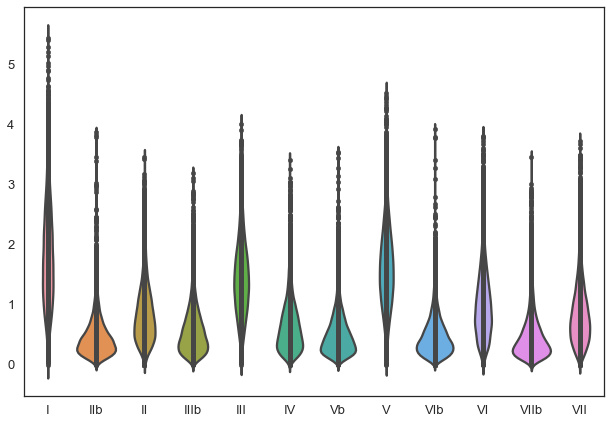

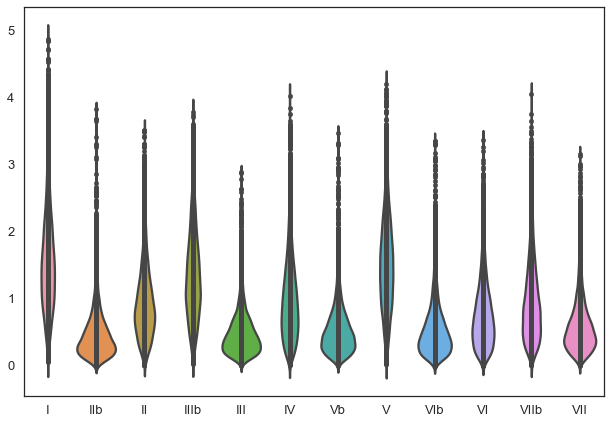

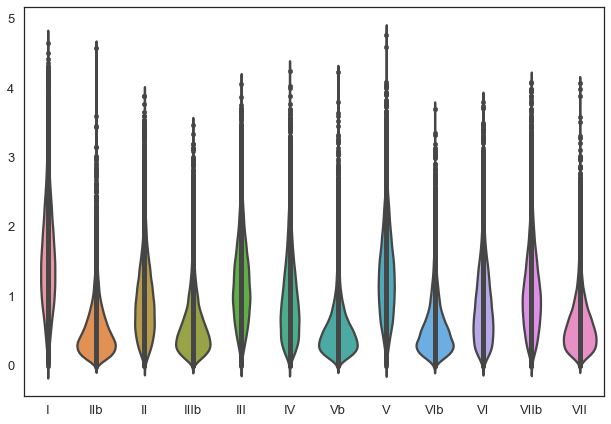

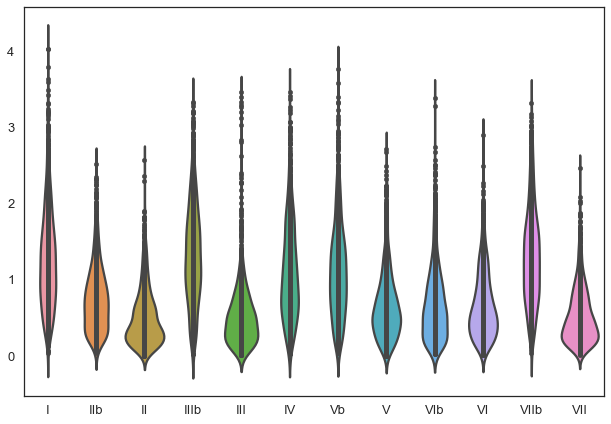

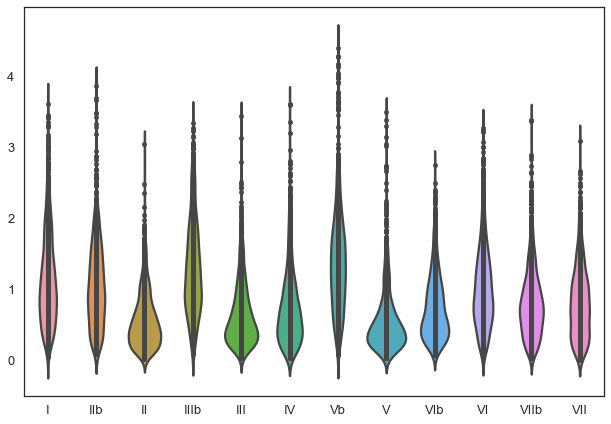

maj 77.9692645445 %
min 70.1673673356 %
dom 52.9434492448 %
hdim7 67.167721519 %
dim 71.0986267166 %
total:  64.5287389605 %
maj BIC:  195403.851089  N:  28
min BIC:  153862.48352  N:  12
dom BIC:  359540.602827  N:  27
hdim7 BIC:  19005.0856283  N:  5
dim BIC:  23294.4585733  N:  6


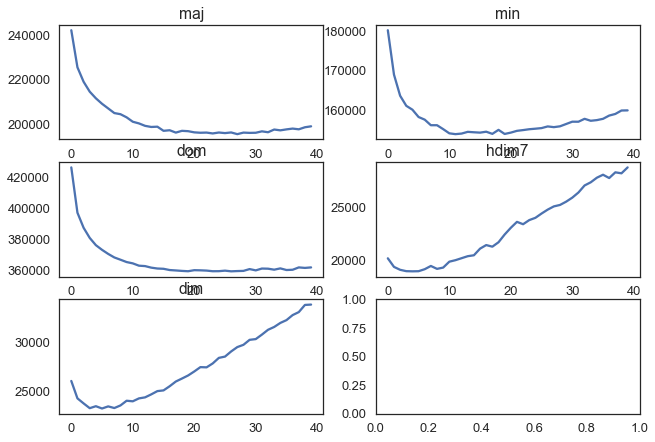

[ 28.  12.  27.   5.   6.]


In [5]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma(chromaFile))

violinPlots12D(kinds, chromas)
model = fitConstModel(kinds, chromas, [1,1,1,1,1])
score(model, kinds, chromas, debug=True)
n_components = findOptimalNComponentsByBIC(chromas)
print n_components


Time span:  1602.17081523
[ 64.84486194  66.49891414  69.66435005  72.40298743  74.50068384
  76.34411817  77.8859107   78.95478633  80.19831544  81.10715868
  82.08883956  82.71259184  84.25226453]
[ 63.06044181  63.76195197  64.87895218  64.47425008  64.96354672
  64.72009912  64.72986525  64.70329951  64.48050791  64.51400135
  64.11016687  63.54169895  63.55068131]


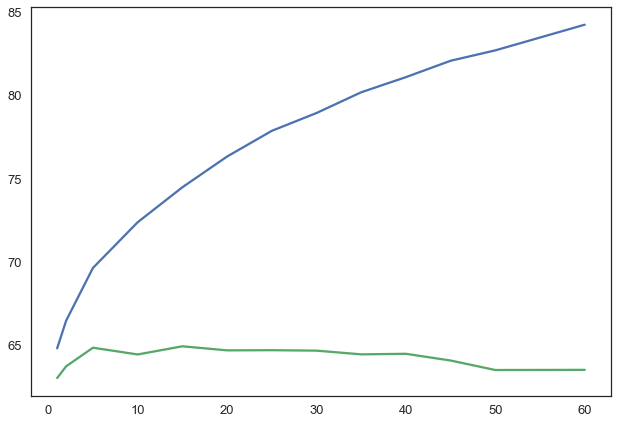

In [6]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma(chromaFile))

start = time.time()
rawTrains, rawTests = trainTestSymmetricalModels(mbids, kinds, chromas, symcomponents)
end = time.time()
print "Time span: ", end-start
print rawTrains
print rawTests
plt.plot(symcomponents, rawTrains)
plt.plot(symcomponents, rawTests)
plt.show()

In [7]:
#np.array([1,2,5,10,15,20,25,30,35,40,45,50,60])

maj BIC:  364995.737599  N:  17
min BIC:  265362.576208  N:  10
dom BIC:  594424.280808  N:  16
hdim7 BIC:  28677.1483448  N:  4
dim BIC:  34782.916749  N:  4


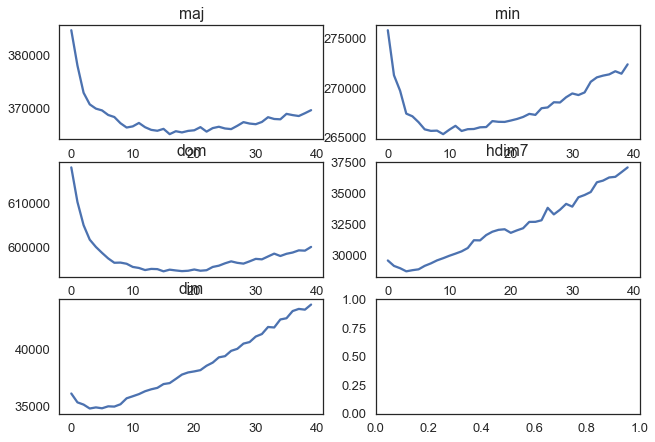

[ 17.  10.  16.   4.   4.]


In [11]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma(chromaFile))

sxChromas = normalizeTo11d(chromas)
#violinPlots11D(kinds, sxChromas)
#model = fitConstModel(kinds, sxChromas, [1,1,1,1,1])
#score(model, kinds, sxChromas, debug=True)
n_components = findOptimalNComponentsByBIC(sxChromas)
print n_components



# Log-ratio transform

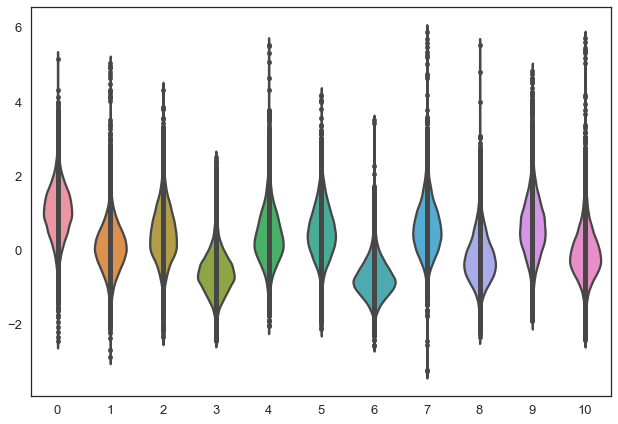

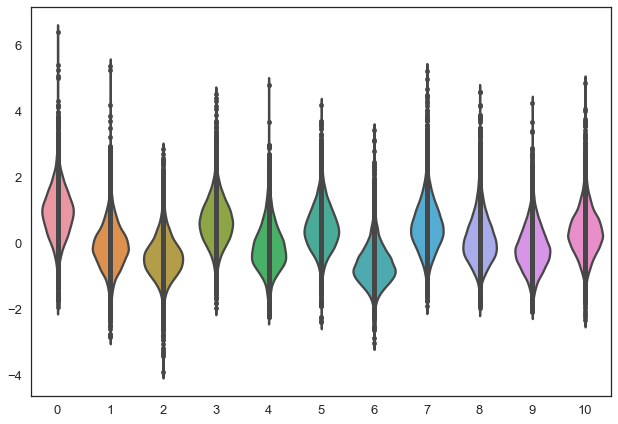

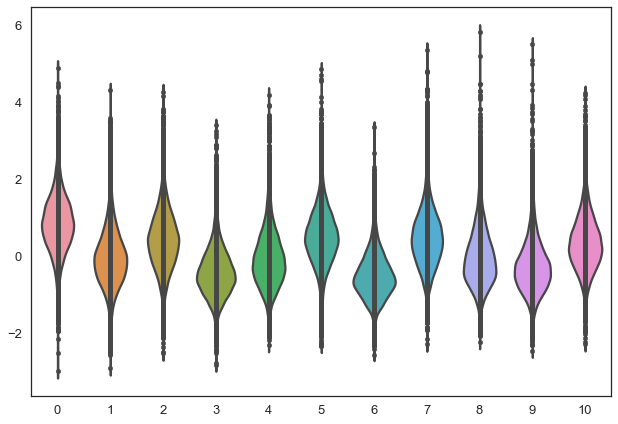

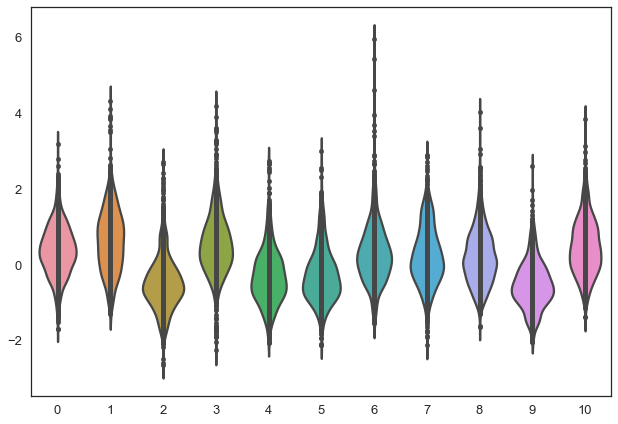

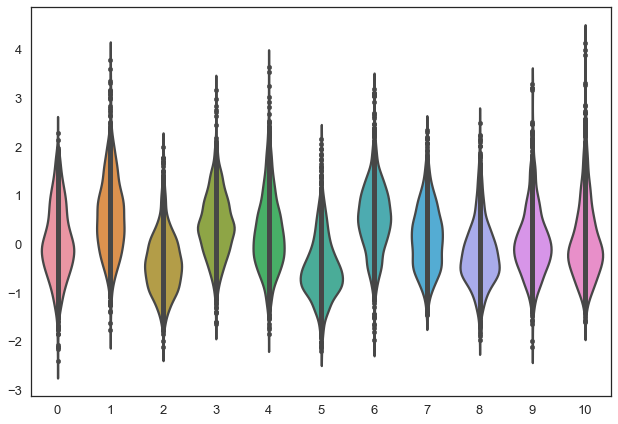

maj 73.0515916575 %
min 72.9832632664 %
dom 62.9293993678 %
hdim7 64.082278481 %
dim 71.7228464419 %
total:  68.1852548944 %
Time span:  1262.25697517
[ 68.33170092  68.64575555  70.63138102  72.87742781  74.49589586
  76.03205199  77.14062853  78.35186331  79.205312    80.1766903
  81.00844317  81.93386404  83.07940536]
[ 66.51919959  66.01778273  65.98562813  65.57538413  65.35677318
  65.22847072  64.99982168  64.76909215  64.80405984  64.39669323
  64.47798658  64.11619233  63.54830137]


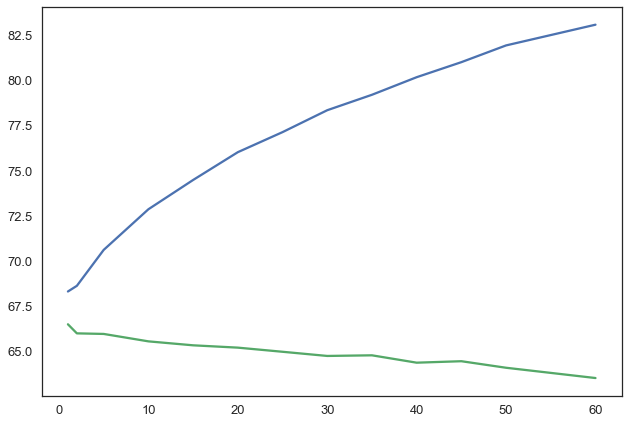

In [8]:
# Compositional data model
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma(chromaFile))

sxChromas = normalizeTo11d(chromas)
start = time.time()
sxTrains, sxTests = trainTestSymmetricalModels(mbids, kinds, sxChromas, symcomponents)
end = time.time()
print "Time span: ", end-start
print sxTrains
print sxTests
plt.plot(symcomponents, sxTrains)
plt.plot(symcomponents, sxTests)
plt.show()




# Just L1

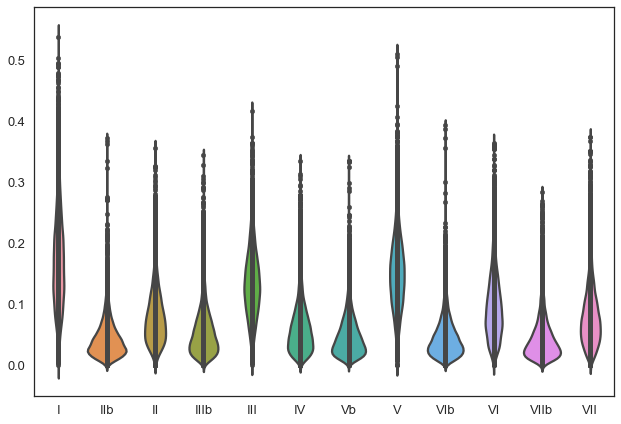

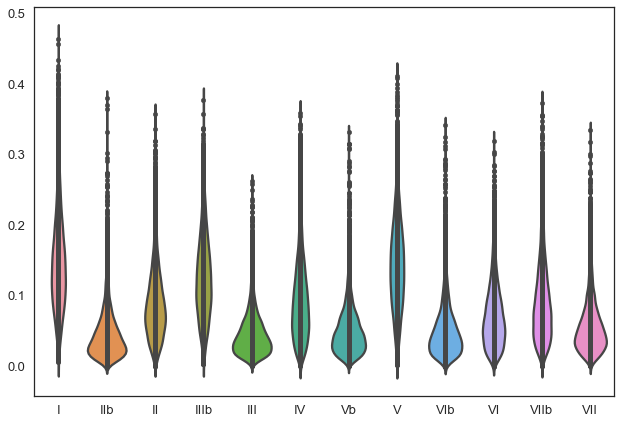

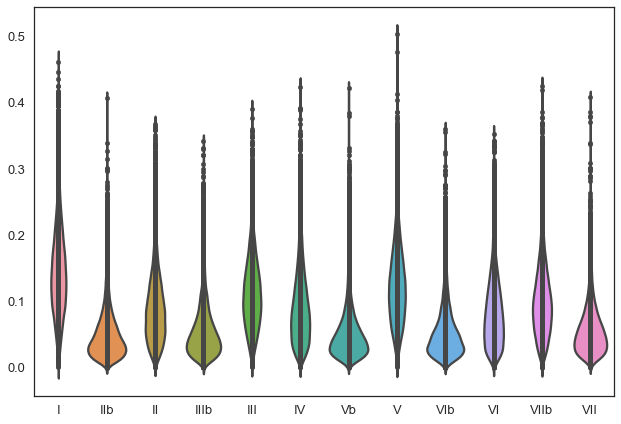

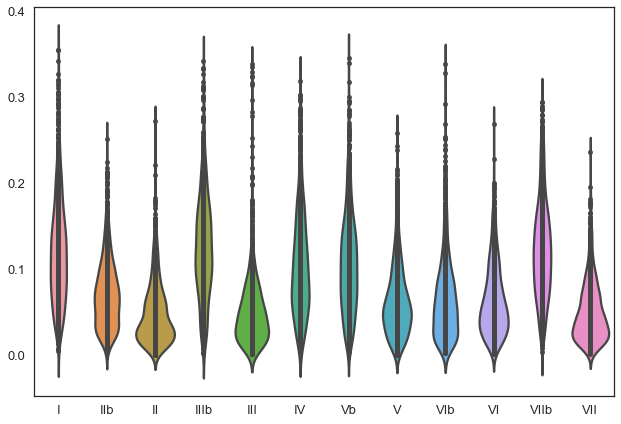

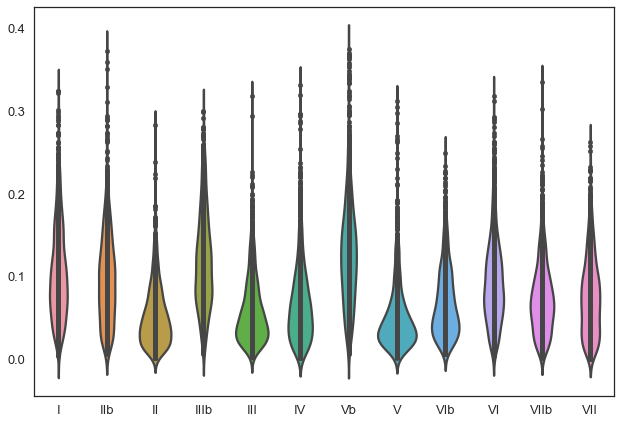

maj 72.7167947311 %
min 74.8473070516 %
dom 47.1022128556 %
hdim7 67.4050632911 %
dim 72.4719101124 %
total:  61.3033476505 %
Time span:  1553.01558614
[ 61.8160351   65.24534114  69.12552326  71.4694497   73.55839585
  75.16864723  76.49391469  77.67879932  78.80236848  79.68954353
  80.53930409  81.48068244  82.83520125]
[ 60.12060949  62.97512025  64.57522817  64.74862069  65.12997312
  65.35557078  64.85705087  65.09060193  64.99820356  64.95049564
  64.74288747  64.44131753  64.08775569]


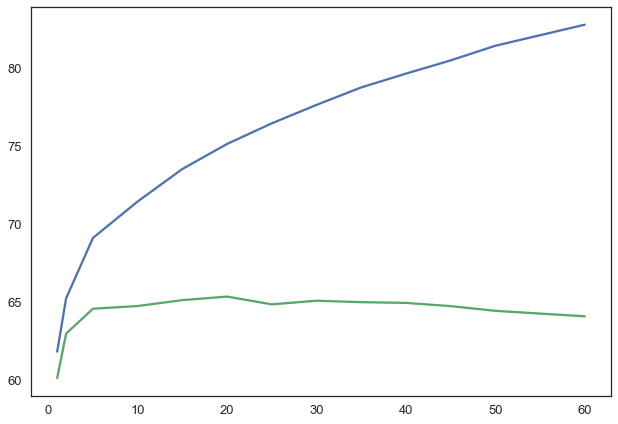

In [12]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma(chromaFile))

l1Chromas = normalize(chromas)
violinPlots12D(kinds, l1Chromas)
model = fitConstModel(kinds, l1Chromas, [1,1,1,1,1])
score(model, kinds, l1Chromas, debug=True)
#n_components = findOptimalNComponentsByBIC(l1Chromas)
#print n_components
start = time.time()
l1Trains, l1Tests = trainTestSymmetricalModels(mbids, kinds, l1Chromas, symcomponents)
end = time.time()
print "Time span: ", end-start
print l1Trains
print l1Tests
plt.plot(symcomponents, l1Trains)
plt.plot(symcomponents, l1Tests)
plt.show()



# L1-log

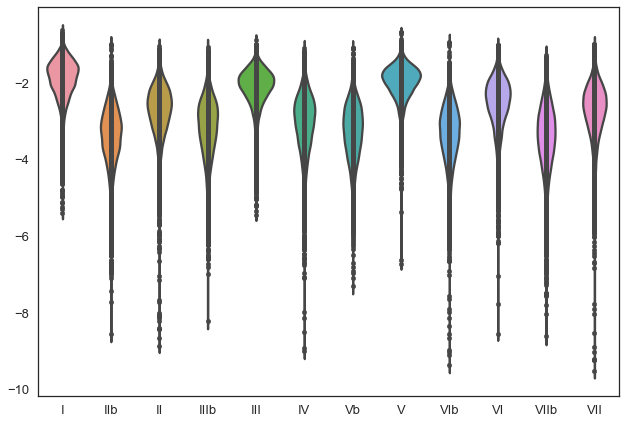

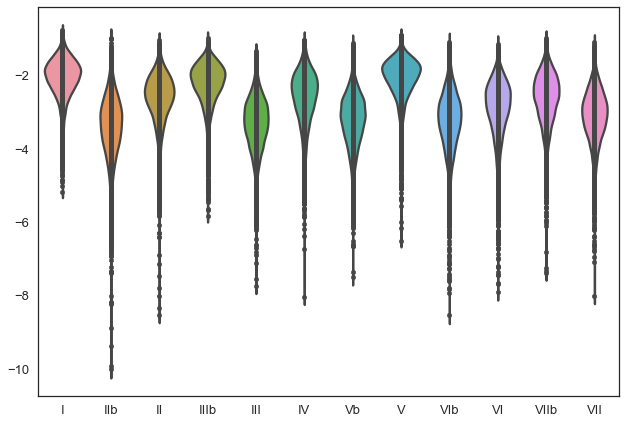

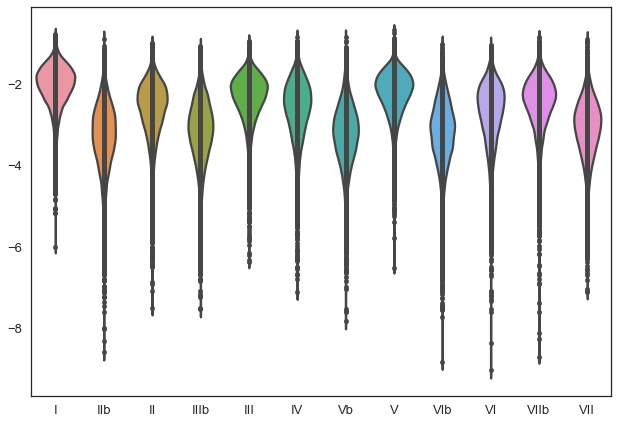

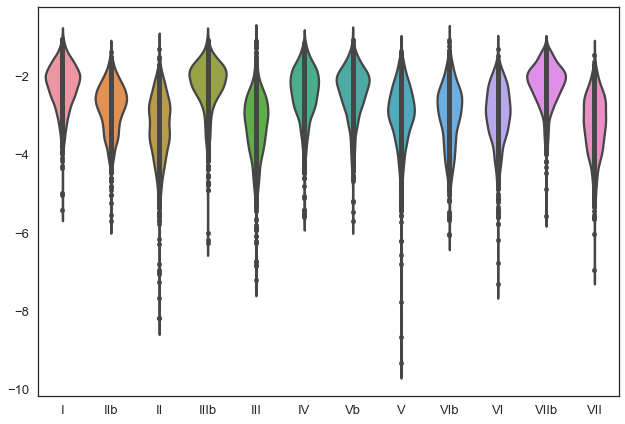

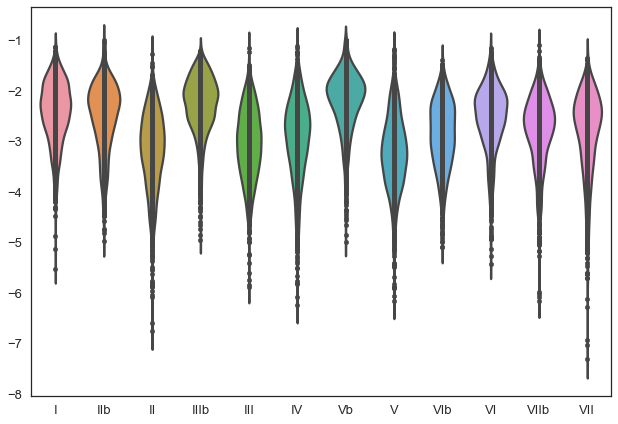

maj 75.6586169045 %
min 73.3243436186 %
dom 61.7421847559 %
hdim7 61.6297468354 %
dim 72.784019975 %
total:  68.4522947734 %
Time span:  1508.06312919
[ 68.55372842  68.21057843  70.27983225  72.48190677  74.01205144
  75.24318587  76.47632302  77.52143738  78.55898373  79.38452798
  80.21098372  81.08374102  82.47324246]
[ 66.56897422  66.08396312  65.86746936  66.1078698   65.6352149
  65.13073447  65.28703702  64.66150693  64.44338975  64.47445303
  64.67281042  64.03896649  63.38457355]


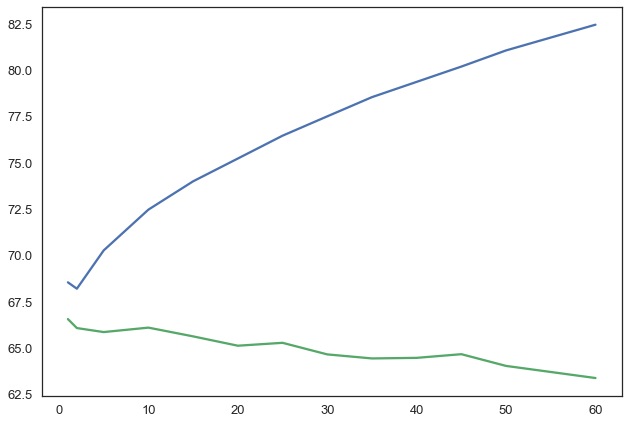

In [13]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma(chromaFile))

l1logChromas = logNormalize(chromas)
violinPlots12D(kinds, l1logChromas)
model = fitConstModel(kinds, l1logChromas, [1,1,1,1,1])
score(model, kinds, l1logChromas, debug=True)
#n_components = findOptimalNComponentsByBIC(l1logChromas)
#print n_components
start = time.time()
l1logTrains, l1logTests = trainTestSymmetricalModels(mbids, kinds, l1logChromas, symcomponents)
end = time.time()
print "Time span: ", end-start
print l1logTrains
print l1logTests
plt.plot(symcomponents, l1logTrains)
plt.plot(symcomponents, l1logTests)
plt.show()


# L2

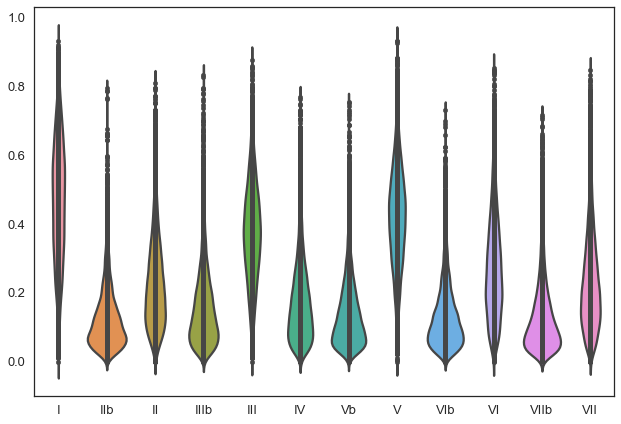

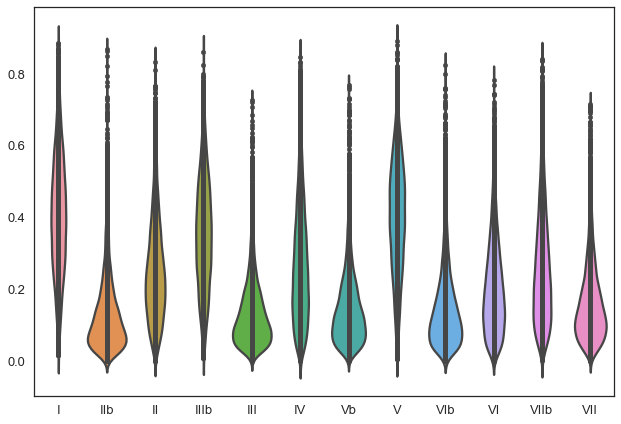

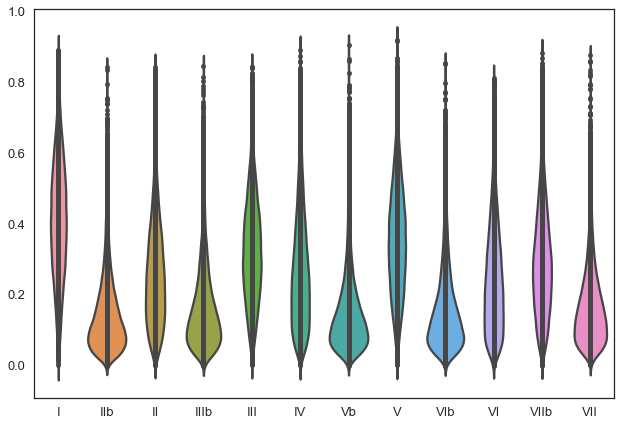

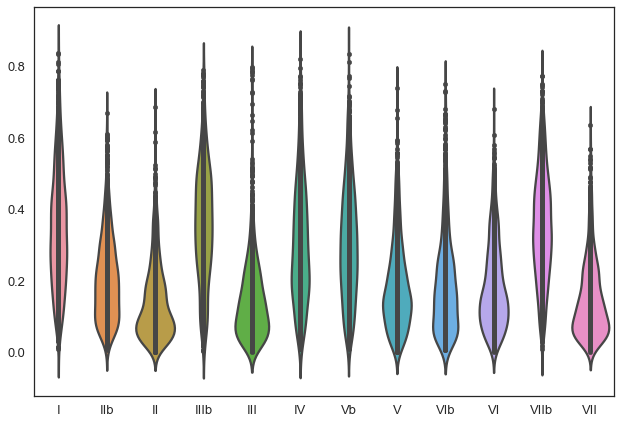

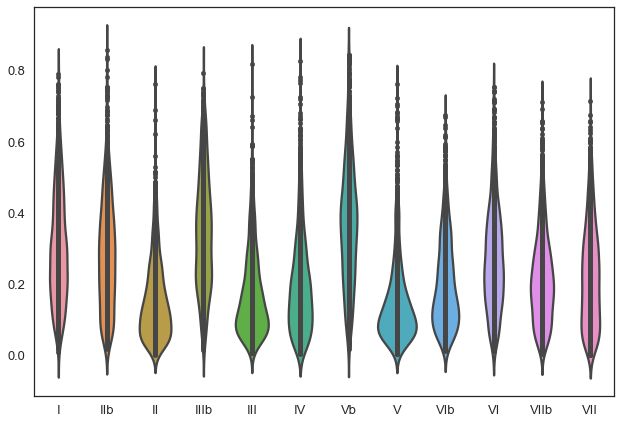

maj 78.5236004391 %
min 69.9532006028 %
dom 52.2690551458 %
hdim7 67.5632911392 %
dim 70.7240948814 %
total:  64.337306758 %
Time span:  1304.36680508
[ 64.56987465  65.70341249  68.78687748  71.22319529  73.12263285
  74.58189419  75.6988666   76.95217884  77.90414102  79.02169587
  79.91096585  80.66527134  82.17961241]
[ 62.85314084  63.05316995  64.66970003  64.29727806  64.92033026
  64.92925436  64.5686933   64.74672225  64.88384545  64.65914628
  64.29897746  64.38661094  63.63480673]


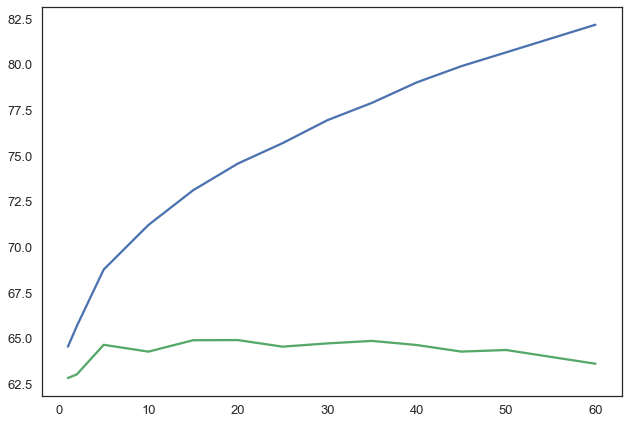

In [14]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma(chromaFile))

l2Chromas = normalize(chromas, norm='l2')
violinPlots12D(kinds, l2Chromas)
model = fitConstModel(kinds, l2Chromas, [1,1,1,1,1])
score(model, kinds, l2Chromas, debug=True)
#model = fitConstModel(kinds, l2Chromas, [1,7,2,1,1])
#score(model, kinds, l2Chromas)
#n_components = findOptimalNComponentsByBIC(l2Chromas)
#print n_components
start = time.time()
l2Trains, l2Tests = trainTestSymmetricalModels(mbids, kinds, l2Chromas, symcomponents)
end = time.time()
print "Time span: ", end-start
print l2Trains
print l2Tests
plt.plot(symcomponents, l2Trains)
plt.plot(symcomponents, l2Tests)
plt.show()



# Lmax

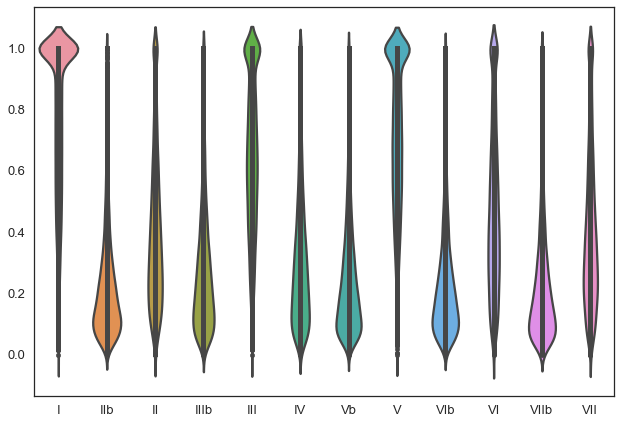

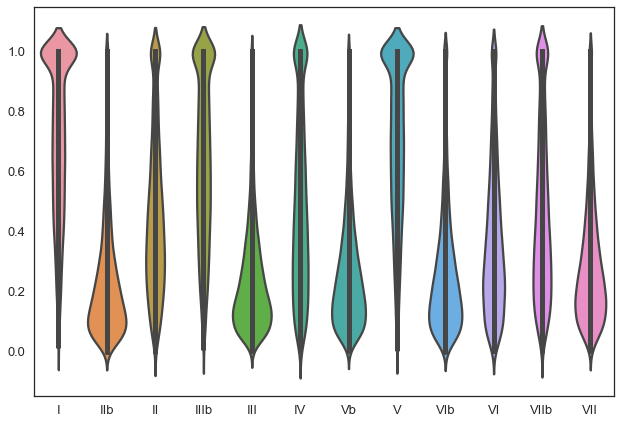

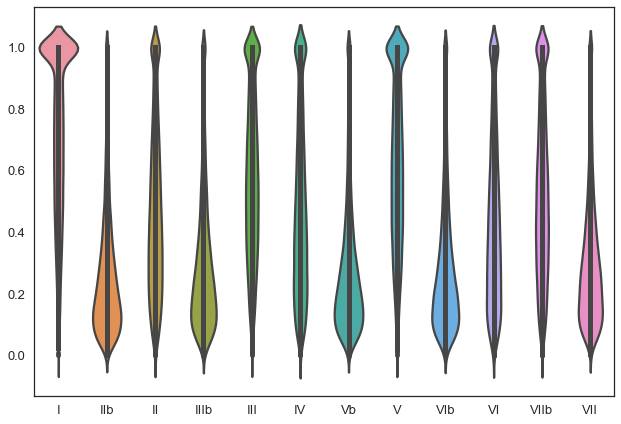

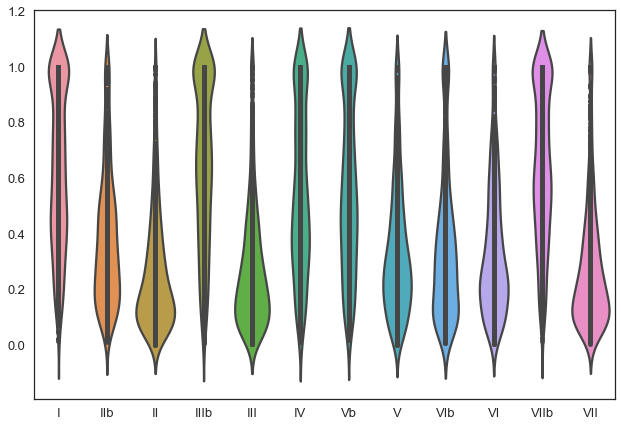

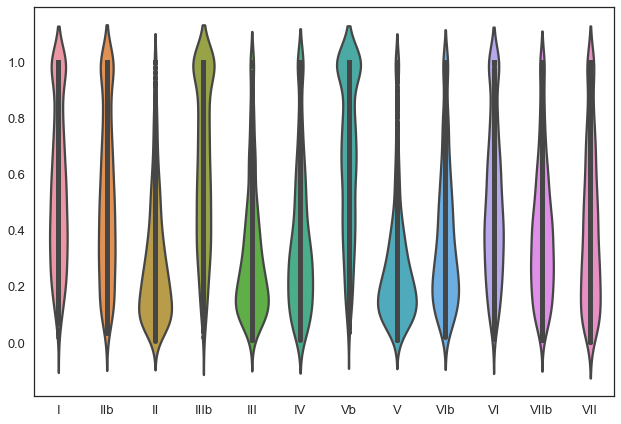

maj 78.2327113063 %
min 69.255175696 %
dom 51.8686336495 %
hdim7 68.3544303797 %
dim 69.6004993758 %
total:  63.9142255039 %
Time span:  1403.75356102
[ 64.2148474   61.9200409   61.88670324  70.71718142  71.88480061
  73.12072592  73.96395181  74.82047857  75.63779726  76.42189347
  77.02437041  77.52767133  78.4843894 ]
[ 62.67623333  59.38303389  59.29786627  66.38713414  66.52925932
  66.90993317  66.79284573  67.18432017  67.4481912   67.63819105
  67.29494846  67.2076716   67.00712227]


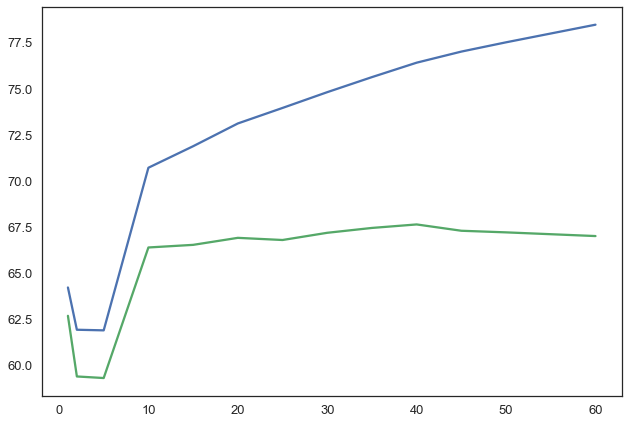

In [15]:
chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma(chromaFile))

maxChromas = normalize(chromas, norm='max')
violinPlots12D(kinds, maxChromas)
model = fitConstModel(kinds, maxChromas, [1,1,1,1,1])
score(model, kinds, maxChromas, debug=True)
#model = fitConstModel(kinds, maxChromas, [2,6,1,1,1])
#score(model, kinds, maxChromas)
#n_components = findOptimalNComponentsByBIC(maxChromas)
#print n_components
start = time.time()
maxTrains, maxTests = trainTestSymmetricalModels(mbids, kinds, maxChromas, symcomponents)
end = time.time()
print "Time span: ", end-start
print maxTrains
print maxTests
plt.plot(symcomponents, maxTrains)
plt.plot(symcomponents, maxTests)
plt.show()

<h1> Recap from previous series.</h1>
I'm working on chord estimation for jazz audio recordings.
Primary task: identify root and chord type:
<ul>
<li> maj
<li> min
<li> dom
<li> hdim7
<li> dim
</ul>

<h2>Idea is to: </h2>
<ul>
<li> detect beats (may be: down beats,  periods by 4, 8 bars, e.g. deeper hierarchy)
<li> for each beat estimate probability of each possible chord
<li> plugin these probabilities into some model to count adjacent chord dependencies
     (and ideally: relation to segments of higher order).
</ul>     

<h2>Done before:</h2>
<ul>
<li> Have 3 datasets ("The Beatles", "Jazz": 62163 beats annotated, "Guitar": 289 beats annotated)
<li> Beat tracking: madmom
<li> NNLS Chroma: appears to be best available as shown with experiment on "The Beatles" dataset.
     Was evaluated only practically.
     Chroma = 12D vector (per value for each semintone pitch class).
<li> Preliminary chroma distribution exploration. Conclusion: after per-sample normalization, it becomes
     very "un Gaussian" (e.g. distributed  in lower dimensional spaece with boundaries, very skewed).
     For L1: it's distributed on simplex. Then, try:
     <ul>
     <li> L1 + logarithm
     <li> L1 + transform to 11D
     </ul>
</ul>

<h2> This week: </h2>
 Fit GMM model to "jazz" and "guitar" dataset. How it's evaluated:
 <ul>
 <li> All chords converted to C (only chord kind is predicted)
 <li> 5-Fold crossvalidation is used
 <li> Naive bayes classifier is applied to trained GMM to detedct chord kind.
 </ul>
 
 <h2> Results: </h2>
 <li> GMM with 60 components gives 75% test accuracy.
      (it's possible to gain almost 100% training accuracy).
      For guitar: 90% test accuracy with simple Gaussian (no mixture).
 <li> NNLS chroma features are not behaved as expected. It seems
      to compress loudness somehow, so normalization isn't necessary.
      It doens't respect perceptual model (masking) and provides counterintuitive
      results. Chroma seems to be a black box now and it's a weak point.
      It seems it could be improved.
 <li> L1 and "Un-simplex": shows better results for low number of components.
      L1 reflects perceptual/musicological approach: (proportions, as in Pitch class profiles). 
      In general, why "unsimplex" is interesting?
      <ul>
      <li> best results for small number of components in GMM
 </ul>

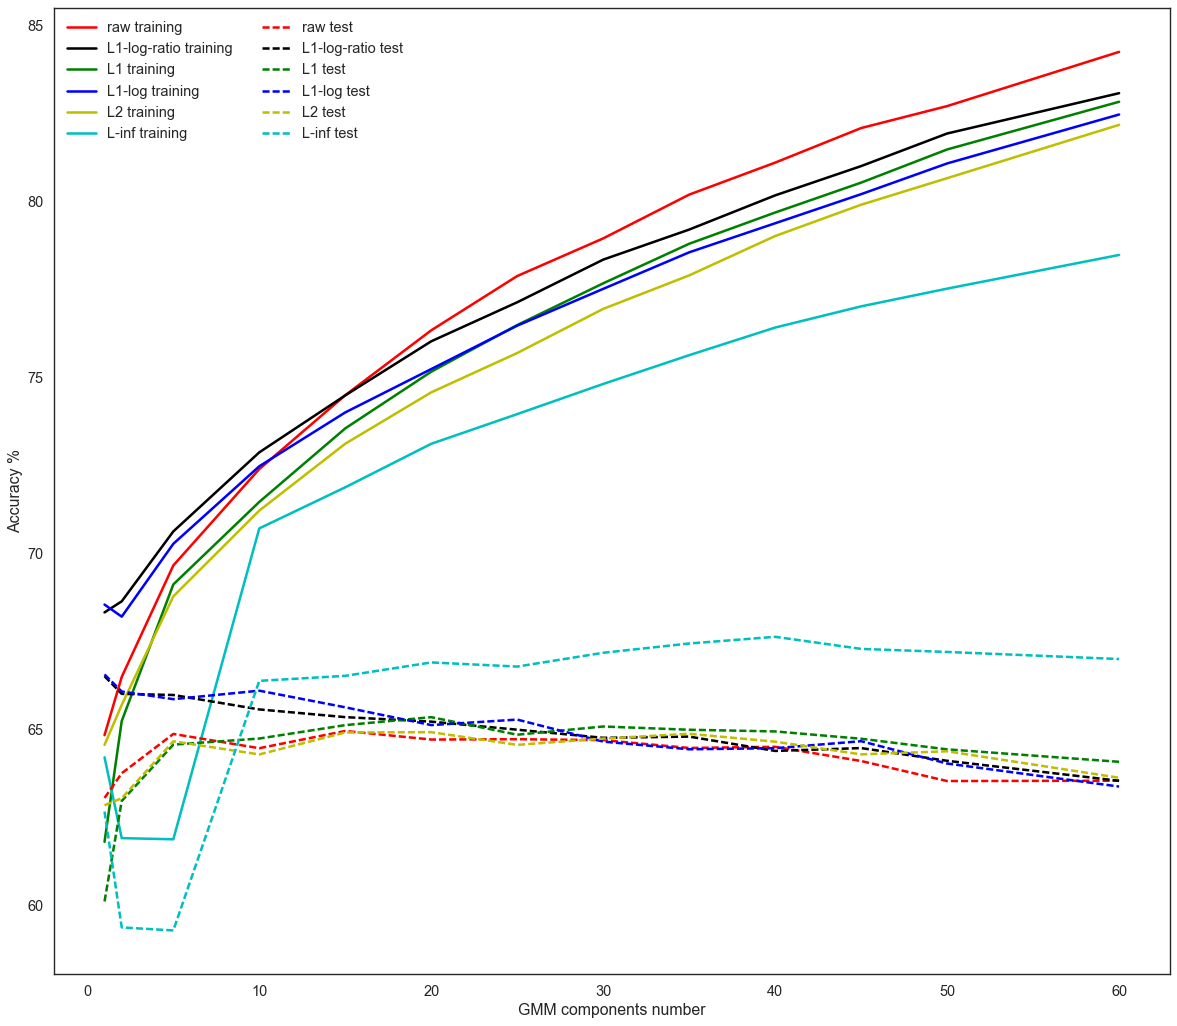

Norm / N of components,1,2,5,10,15,20,25,30,35,40,45,50,60
Raw,64.84,66.5,69.66,72.4,74.5,76.34,77.89,78.95,80.2,81.11,82.09,82.71,84.25
L1-log-ratio,68.33,68.65,70.63,72.88,74.5,76.03,77.14,78.35,79.21,80.18,81.01,81.93,83.08
L1 training,61.82,65.25,69.13,71.47,73.56,75.17,76.49,77.68,78.8,79.69,80.54,81.48,82.84
L1-log training,68.55,68.21,70.28,72.48,74.01,75.24,76.48,77.52,78.56,79.38,80.21,81.08,82.47
L2 training,64.57,65.7,68.79,71.22,73.12,74.58,75.7,76.95,77.9,79.02,79.91,80.67,82.18
L-inf training,64.21,61.92,61.89,70.72,71.88,73.12,73.96,74.82,75.64,76.42,77.02,77.53,78.48


Norm / N of components,1,2,5,10,15,20,25,30,35,40,45,50,60
Raw,63.06,63.76,64.88,64.47,64.96,64.72,64.73,64.7,64.48,64.51,64.11,63.54,63.55
L1-log-ratio,66.52,66.02,65.99,65.58,65.36,65.23,65.0,64.77,64.8,64.4,64.48,64.12,63.55
L1 test,60.12,62.98,64.58,64.75,65.13,65.36,64.86,65.09,65.0,64.95,64.74,64.44,64.09
L1-log,66.57,66.08,65.87,66.11,65.64,65.13,65.29,64.66,64.44,64.47,64.67,64.04,63.38
L2 test,62.85,63.05,64.67,64.3,64.92,64.93,64.57,64.75,64.88,64.66,64.3,64.39,63.63
L-inf test,62.68,59.38,59.3,66.39,66.53,66.91,66.79,67.18,67.45,67.64,67.29,67.21,67.01


In [18]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
line, = plt.plot(symcomponents, rawTrains, 'r-')
line.set_label('raw training')
line, = plt.plot(symcomponents, sxTrains, 'k-')
line.set_label('L1-log-ratio training')
line, = plt.plot(symcomponents, l1Trains, 'g-')
line.set_label('L1 training')
line, = plt.plot(symcomponents, l1logTrains, 'b-')
line.set_label('L1-log training')
line, = plt.plot(symcomponents, l2Trains, 'y-')
line.set_label('L2 training')
line, = plt.plot(symcomponents, maxTrains, 'c-')
line.set_label('L-inf training')

line, = plt.plot(symcomponents, rawTests, 'r--')
line.set_label('raw test')
line, = plt.plot(symcomponents, sxTests, 'k--')
line.set_label('L1-log-ratio test')
line, = plt.plot(symcomponents, l1Tests, 'g--')
line.set_label('L1 test')
line, = plt.plot(symcomponents, l1logTests, 'b--')
line.set_label('L1-log test')
line, = plt.plot(symcomponents, l2Tests, 'y--')
line.set_label('L2 test')
line, = plt.plot(symcomponents, maxTests, 'c--')
line.set_label('L-inf test')

plt.xlabel('GMM components number')
plt.ylabel('Accuracy %')
plt.legend(ncol=2)
plt.show()
from IPython.display import HTML, display
def line2HTML(title, data):
    return '<tr><td>' + title + '</td><td>{}</td></tr>'.format(
        '</td><td>'.join(str(round(x,2)) for x in data))

header = '<tr><th>Norm / N of components</th><th>{}</th></tr>'.format('</th><th>'.join(str(x) for x in symcomponents))
body = ''
body = body + line2HTML('Raw', rawTrains)
body = body + line2HTML('L1-log-ratio', sxTrains)
body = body + line2HTML('L1', l1Trains)
body = body + line2HTML('L1-log', l1logTrains)
body = body + line2HTML('L2', l2Trains)
body = body + line2HTML('L-inf', maxTrains)
display(HTML('<h3>Training Accuracy %</h3><table>' + header + body + '</table>'))

header = '<tr><th>Norm / N of components</th><th>{}</th></tr>'.format('</th><th>'.join(str(x) for x in symcomponents))
body = ''
body = body + line2HTML('Raw', rawTests)
body = body + line2HTML('L1-log-ratio', sxTests)
body = body + line2HTML('L1 test', l1Tests)
body = body + line2HTML('L1-log', l1logTests)
body = body + line2HTML('L2 test', l2Tests)
body = body + line2HTML('L-inf test', maxTests)
display(HTML('<h3>Test Accuracy %</h3><table>' + header + body + '</table>'))

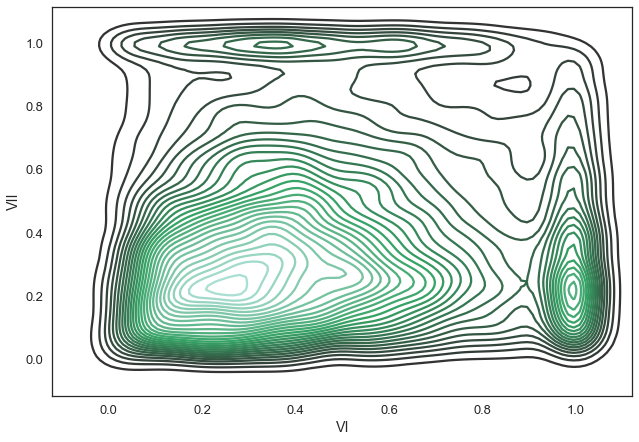

True
-279196.65752
[ 0.13161438  0.1298228   0.02219622  0.23569096  0.01473377  0.14479887
  0.01632631  0.07388903  0.03811276  0.03998257  0.15158786  0.00124446]


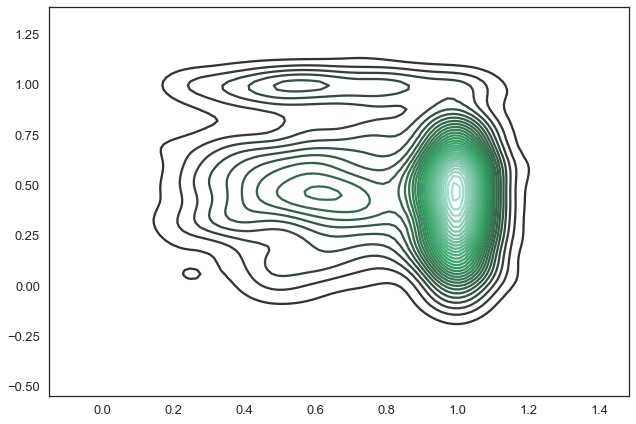

In [29]:
dMaj = pd.DataFrame(data=maxChromas[kinds =='maj'], columns=degrees)

sns.kdeplot(dMaj['VI'], dMaj['VII'], n_levels=30)
plt.show()
gm = fitMixture(dMaj.values, n_components=12)
gmMaj = gm
print gm.converged_
print gm.bic(dMaj)
print gm.weights_

samples = np.asarray(gm.sample(1000)[0])
samples[:,[0, 9]].shape
sns.kdeplot(samples[:,[0, 9]], n_levels=30)
plt.show()

In [26]:
from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold
from scipy.misc import logsumexp
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn import linear_model, datasets
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

chromas, labels, kinds, mbids, start_times, durations = removeUnclassified(chordUtils.loadDatasetChroma(chromaFile))

clf = svm.SVC(C=11, kernel = 'rbf', gamma=1.0)
kf = MBIDAwareKFold(n_splits = 5, random_state = 8)
svm_scores = cross_val_score(clf, chromas, kinds, cv=kf.split(mbids), n_jobs=-1)
score = svm_scores.mean()
print "Test error (on crossvalidation):", score * 100.0, '%'

Test error (on crossvalidation): 65.1896362217 %


In [27]:
# train error
clf = svm.SVC(C=11, kernel = 'rbf', gamma=1.0)
clf.fit(chromas, kinds)
print "Train error:", clf.score(chromas, kinds) * 100.0, '%'


0.965300902466
